In [1]:
# %pip install opencv-python
%pip install imageio[ffmpeg]
%pip install tqdm

In [2]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/gdrive')
# Define base folder path
base_path = '/content/gdrive/MyDrive/RGB_data_stream'

Mounted at /content/gdrive


In [3]:
import os

csv_path = os.path.join(base_path,'data/3DYoga90.csv')
sequence_path = os.path.join(base_path, 'short/downloaded_log.txt')
save_path = os.path.join(base_path, 'SECOND_mobile_net_nov2')
os.makedirs(save_path, exist_ok=True)
pose_list = ['mountain', 'half-way-lift', 'standing-forward-bend', 'downward-dog']
NUM_CLASSES = len(pose_list)
video_dir = os.path.join(base_path, 'short')
preprocessed_dir = os.path.join(base_path, 'pre_processed_short')
os.makedirs(preprocessed_dir, exist_ok=True)

In [4]:
# Constants
FRAME_HEIGHT = 224  # VGG16 input size
FRAME_WIDTH = 224
SEQUENCE_LENGTH = 16

BATCH_SIZE = 32
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1
NUM_EPOCHS = 20

# Dataset

Work Left
1. Data Augmentation
2. Expanding to more classes

In [5]:
import os
import torch
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import imageio

class YogaVideoDataset(Dataset):
    def __init__(self, csv_path, sequence_path, pose_list, video_dir, preprocessed_dir):
        with open(sequence_path) as f:
            sequence_list = f.read().splitlines()
            sequence_list = [int(x) for x in sequence_list]

        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['sequence_id'].isin(sequence_list)]
        self.df = self.df[self.df['l3_pose'].isin(pose_list)]

        self.pose_to_idx = {pose: idx for idx, pose in enumerate(pose_list)}
        self.length_of_dataset = len(self.df)

        self.video_dir = video_dir
        self.preprocessed_dir = preprocessed_dir

        os.makedirs(self.preprocessed_dir, exist_ok=True)

        self.transforms = transforms.Compose([
            transforms.Resize((FRAME_HEIGHT, FRAME_WIDTH)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.cache = dict()

    def __len__(self):
        return self.length_of_dataset

    def __getitem__(self, i):
        sequence_id = self.df.iloc[i]['sequence_id']
        pose = self.df.iloc[i]['l3_pose']
        label = self.pose_to_idx[pose]

        # Check cache first
        if sequence_id in self.cache:
            frames = self.cache[sequence_id]
        else:
            # Path to preprocessed tensor file
            preprocessed_path = os.path.join(self.preprocessed_dir, f"{sequence_id}.pt")

            if os.path.exists(preprocessed_path):
                frames = torch.load(preprocessed_path, weights_only=True)
            else:
                # Process and save if not already preprocessed
                video_path = os.path.join(self.video_dir, f"{sequence_id}.mp4")
                frames = self._get_frames(video_path)
                torch.save(frames, preprocessed_path)

            # Add to cache
            self.cache[sequence_id] = frames

        return frames, label

    def _get_frames(self, video_path):
        reader = imageio.get_reader(video_path, 'ffmpeg')
        total_frames = reader.count_frames()
        indices = np.linspace(0, total_frames - 1, SEQUENCE_LENGTH, dtype=int)

        frames = []
        for i, frame in enumerate(reader):
            if i in indices:
                frame = Image.fromarray(frame)
                frame = self.transforms(frame)
                frames.append(frame)

        reader.close()
        frames = torch.stack(frames)
        return frames

# Model
``` (mobile_net to get feature map and LSTM to go through the frame sequences)```
Trying out average of LSTM from each time_step
Work Left
1. Using only last time step output from LSTM to using average value, max value, using attention mechanism
2. Using other imagenet model to extract the feature map

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class CNNLSTM(nn.Module):
    def __init__(self, num_classes, lstm_hidden_size=512, lstm_layers=2, dropout=0.5):
        super(CNNLSTM, self).__init__()

        # Load pretrained MobileNetV2
        mobilenet = models.mobilenet_v2(pretrained=True)
        # Remove the classifier
        self.features = nn.Sequential(*list(mobilenet.features))

        # Add adaptive pooling to get fixed size output
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Freeze MobileNetV2 parameters
        for param in self.features.parameters():
            param.requires_grad = False

        # MobileNetV2 outputs 1280 features after pooling
        self.feature_size = 1280

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=self.feature_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()

        # Process each frame through CNN
        x = x.view(batch_size * seq_length, c, h, w)
        x = self.features(x)
        x = self.pool(x)

        # Reshape for LSTM: flatten the spatial dimensions
        x = x.view(batch_size, seq_length, self.feature_size)

        # LSTM processing
        lstm_out, _ = self.lstm(x)

        # Average the LSTM outputs across time steps
        x = torch.mean(lstm_out, dim=1)

        # Classification
        x = self.classifier(x)

        return x

In [7]:
from torch.utils.data import random_split

def train_val_test_split(dataset):
    total_size = len(dataset)
    test_size = int(TEST_SPLIT * total_size)
    val_size = int(VALIDATION_SPLIT * total_size)
    train_size = total_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    return train_dataset, val_dataset, test_dataset

def create_data_loaders(train_dataset, val_dataset, test_dataset):
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory = True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory = True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory = True
    )

    return train_loader, val_loader, test_loader

In [15]:
def plot_training_curves(history, fsave='training_curves.png'):
    tsave = os.path.join(save_path, fsave)
    # plt.style.use('seaborn')
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Loss curves
    axs[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0, 0].plot(history['val_loss'], label='Validation Loss', marker='o')
    axs[0, 0].set_title('Loss')
    axs[0, 0].legend()

    # Accuracy curves
    axs[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o')
    axs[0, 1].plot(history['val_acc'], label='Validation Accuracy', marker='o')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].legend()

    # Learning rate
    axs[0, 2].plot(history['learning_rates'], label='Learning Rate', marker='o')
    axs[0, 2].set_title('Learning Rate')
    axs[0, 2].set_yscale('log')
    axs[0, 2].legend()

    # Precision
    axs[1, 0].plot(history['train_precision'], label='Train Precision', marker='o')
    axs[1, 0].plot(history['val_precision'], label='Validation Precision', marker='o')
    axs[1, 0].set_title('Precision')
    axs[1, 0].legend()

    # Recall
    axs[1, 1].plot(history['train_recall'], label='Train Recall', marker='o')
    axs[1, 1].plot(history['val_recall'], label='Validation Recall', marker='o')
    axs[1, 1].set_title('Recall')
    axs[1, 1].legend()

    # F1 Score
    axs[1, 2].plot(history['train_f1'], label='Train F1', marker='o')
    axs[1, 2].plot(history['val_f1'], label='Validation F1', marker='o')
    axs[1, 2].set_title('F1 Score')
    axs[1, 2].legend()

    for ax in axs.flat:
        ax.set_xlabel('Epoch')
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(tsave)
    plt.show()
    plt.close()


In [9]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        # on default = 7 successive val_loss increase stop
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [10]:
import os
import torch
def save_checkpoint(model, optimizer, epoch, history, best_path=None):
    if best_path is not None:
        chk_path = os.path.join(save_path, f'best_model.pth')
        print(f"Saving checkpoint to {chk_path}")
    else:
        chk_path = os.path.join(save_path, f'checkpath_model.pth')
        print(f"Saving checkpoint to {chk_path}")

    # Combine model, optimizer, and history into one dictionary
    checkpoint = {
        'epoch': epoch + 1,  # Save the next epoch number for resuming
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history  # Save history along with the model and optimizer
    }

    # Save everything in a single file using torch.save
    torch.save(checkpoint, chk_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

In [17]:
def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Load model and training state from a checkpoint
    """
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)

    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Get the epoch number to resume from
    start_epoch = checkpoint['epoch']

    # Load training history with new metrics
    history = checkpoint.get('history', {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    })

    return model, optimizer, start_epoch, history


In [12]:
import torch
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=50, patience=7, log_interval=10, checkpoint_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print("Using device:", device)

    # Initialize scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Initialize early stopping (example implementation; you may need to define your own)
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)

    start_epoch = 0
    best_val_loss = float('inf')

    # Initialize history for loss, accuracy, precision, recall, and F1
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    }

    # Check for checkpoint and load if available
    if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(
            model, optimizer, checkpoint_path
        )
        print(f"Resuming training from epoch {start_epoch}")
        torch.cuda.empty_cache()

    for epoch in range(start_epoch, num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        print(f"Current Learning Rate: {current_lr}")

        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_true, train_pred = [], []

        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (inputs, labels) in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # Collect true and predicted labels for precision/recall
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(predicted.cpu().numpy())

            # Log batch-level updates
            if batch_idx % log_interval == 0:
                train_loader_tqdm.set_postfix({
                    'loss': train_loss / (batch_idx + 1),
                    'accuracy': 100.0 * train_correct / train_total
                })

        # Calculate training metrics
        train_loss /= len(train_loader)
        train_acc = 100.0 * train_correct / train_total
        train_precision = precision_score(train_true, train_pred, average='weighted')
        train_recall = recall_score(train_true, train_pred, average='weighted')
        train_f1 = f1_score(train_true, train_pred, average='weighted')

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_true, val_pred = [], []

        val_loader_tqdm = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")
        with torch.no_grad():
            for batch_idx, (inputs, labels) in val_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # Collect true and predicted labels for precision/recall
                val_true.extend(labels.cpu().numpy())
                val_pred.extend(predicted.cpu().numpy())

                # Log batch-level updates for validation
                if batch_idx % log_interval == 0:
                    val_loader_tqdm.set_postfix({
                        'loss': val_loss / (batch_idx + 1),
                        'accuracy': 100.0 * val_correct / val_total
                    })

        # Calculate validation metrics
        val_loss /= len(val_loader)
        val_acc = 100.0 * val_correct / val_total
        val_precision = precision_score(val_true, val_pred, average='weighted')
        val_recall = recall_score(val_true, val_pred, average='weighted')
        val_f1 = f1_score(val_true, val_pred, average='weighted')

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        # Print metrics at the end of the epoch
        print(f'\nEpoch {epoch+1}/{num_epochs} Summary:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train Precision: {train_precision:.2f} | Train Recall: {train_recall:.2f} | Train F1: {train_f1:.2f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val Precision: {val_precision:.2f} | Val Recall: {val_recall:.2f} | Val F1: {val_f1:.2f}')

        # Save the best model checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(save_path, 'best_model.pth')
            save_checkpoint(model, optimizer, epoch, history, best_model_path)
            print(f"New best model saved! Validation Loss: {best_val_loss:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model, history






In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import numpy as np
import os
from tqdm import tqdm

def evaluate_model(model, test_loader, criterion, class_names,spath=save_path, fsave='confusion_matrix.png'):
    """
    Evaluate model on test set

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        save_path: Directory to save the plot
        fsave: Filename for confusion matrix plot
    """
    csave = os.path.join(spath, fsave)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    # Create progress bar
    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for inputs, labels in test_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            # Calculate accuracy
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    test_loss = test_loss / len(test_loader)
    accuracy = 100 * test_correct / test_total

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the plot
    plt.savefig(csave)
    plt.show()
    plt.close()

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

In [14]:
print("Loading Data")
dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir, preprocessed_dir)
train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)
print("Finished Loading Data")

model = CNNLSTM(num_classes=NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Training the model")
checkpoint_path = os.path.join(save_path, 'checkpath_model.pth')
model, history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    NUM_EPOCHS,
    patience=7,
    log_interval=10,
    checkpoint_path=checkpoint_path
)
# Plot the training curves
plot_training_curves(history)
if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(
            model, optimizer, checkpoint_path
        )
        print(f"Resuming training from epoch {start_epoch}")
evaluate_model(model, test_loader, criterion, pose_list)

model_save_path = os.path.join(save_path, 'my_model.pth')
torch.save(model.state_dict(), model_save_path)

Loading Data


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Finished Loading Data


100%|██████████| 13.6M/13.6M [00:00<00:00, 129MB/s]


Training the model
Using device: cuda

Epoch 1/20
Current Learning Rate: 0.001


Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipyt


Epoch 1/20 Summary:
Train Loss: 1.3500 | Train Acc: 30.45% | Train Precision: 0.28 | Train Recall: 0.30 | Train F1: 0.27
Val Loss: 1.3760 | Val Acc: 32.61% | Val Precision: 0.42 | Val Recall: 0.33 | Val F1: 0.27
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/SECOND_mobile_net_nov2/best_model.pth
Checkpoint saved at epoch 1
New best model saved! Validation Loss: 1.3760

Epoch 2/20
Current Learning Rate: 0.001


Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipyt


Epoch 2/20 Summary:
Train Loss: 1.2194 | Train Acc: 46.71% | Train Precision: 0.46 | Train Recall: 0.47 | Train F1: 0.43
Val Loss: 1.4950 | Val Acc: 34.06% | Val Precision: 0.43 | Val Recall: 0.34 | Val F1: 0.22

Epoch 3/20
Current Learning Rate: 0.001



<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipy


Epoch 3/20 Summary:
Train Loss: 1.1335 | Train Acc: 48.35% | Train Precision: 0.48 | Train Recall: 0.48 | Train F1: 0.46
Val Loss: 1.0533 | Val Acc: 48.55% | Val Precision: 0.48 | Val Recall: 0.49 | Val F1: 0.44
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/SECOND_mobile_net_nov2/best_model.pth
Checkpoint saved at epoch 3
New best model saved! Validation Loss: 1.0533

Epoch 4/20
Current Learning Rate: 0.001


Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipyt


Epoch 4/20 Summary:
Train Loss: 1.0516 | Train Acc: 52.88% | Train Precision: 0.52 | Train Recall: 0.53 | Train F1: 0.52
Val Loss: 1.3338 | Val Acc: 44.20% | Val Precision: 0.42 | Val Recall: 0.44 | Val F1: 0.37

Epoch 5/20
Current Learning Rate: 0.001



Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipy


Epoch 5/20 Summary:
Train Loss: 1.0353 | Train Acc: 52.06% | Train Precision: 0.51 | Train Recall: 0.52 | Train F1: 0.51
Val Loss: 0.8665 | Val Acc: 66.67% | Val Precision: 0.69 | Val Recall: 0.67 | Val F1: 0.66
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/SECOND_mobile_net_nov2/best_model.pth
Checkpoint saved at epoch 5
New best model saved! Validation Loss: 0.8665

Epoch 6/20
Current Learning Rate: 0.001


Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipyt


Epoch 6/20 Summary:
Train Loss: 1.0114 | Train Acc: 55.56% | Train Precision: 0.55 | Train Recall: 0.56 | Train F1: 0.55
Val Loss: 0.9166 | Val Acc: 59.42% | Val Precision: 0.70 | Val Recall: 0.59 | Val F1: 0.59

Epoch 7/20
Current Learning Rate: 0.001



Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipy


Epoch 7/20 Summary:
Train Loss: 0.7809 | Train Acc: 68.52% | Train Precision: 0.69 | Train Recall: 0.69 | Train F1: 0.69
Val Loss: 0.9359 | Val Acc: 65.94% | Val Precision: 0.72 | Val Recall: 0.66 | Val F1: 0.62

Epoch 8/20
Current Learning Rate: 0.001



Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipy


Epoch 8/20 Summary:
Train Loss: 0.8285 | Train Acc: 66.67% | Train Precision: 0.66 | Train Recall: 0.67 | Train F1: 0.66
Val Loss: 1.2420 | Val Acc: 50.72% | Val Precision: 0.54 | Val Recall: 0.51 | Val F1: 0.45

Epoch 9/20
Current Learning Rate: 0.001


Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipyt


Epoch 9/20 Summary:
Train Loss: 0.8070 | Train Acc: 69.75% | Train Precision: 0.70 | Train Recall: 0.70 | Train F1: 0.70
Val Loss: 0.7585 | Val Acc: 72.46% | Val Precision: 0.74 | Val Recall: 0.72 | Val F1: 0.73
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/SECOND_mobile_net_nov2/best_model.pth
Checkpoint saved at epoch 9
New best model saved! Validation Loss: 0.7585

Epoch 10/20
Current Learning Rate: 0.001


Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipyt


Epoch 10/20 Summary:
Train Loss: 0.7565 | Train Acc: 75.10% | Train Precision: 0.75 | Train Recall: 0.75 | Train F1: 0.75
Val Loss: 1.3455 | Val Acc: 61.59% | Val Precision: 0.69 | Val Recall: 0.62 | Val F1: 0.60

Epoch 11/20
Current Learning Rate: 0.001


Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipyt


Epoch 11/20 Summary:
Train Loss: 0.6251 | Train Acc: 76.75% | Train Precision: 0.77 | Train Recall: 0.77 | Train F1: 0.77
Val Loss: 1.0840 | Val Acc: 60.14% | Val Precision: 0.71 | Val Recall: 0.60 | Val F1: 0.54

Epoch 12/20
Current Learning Rate: 0.001



Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipy


Epoch 12/20 Summary:
Train Loss: 0.4915 | Train Acc: 82.72% | Train Precision: 0.83 | Train Recall: 0.83 | Train F1: 0.83
Val Loss: 1.1233 | Val Acc: 67.39% | Val Precision: 0.73 | Val Recall: 0.67 | Val F1: 0.68

Epoch 13/20
Current Learning Rate: 0.001



<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipy


Epoch 13/20 Summary:
Train Loss: 0.4905 | Train Acc: 82.10% | Train Precision: 0.82 | Train Recall: 0.82 | Train F1: 0.82
Val Loss: 0.6973 | Val Acc: 77.54% | Val Precision: 0.78 | Val Recall: 0.78 | Val F1: 0.78
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/SECOND_mobile_net_nov2/best_model.pth
Checkpoint saved at epoch 13
New best model saved! Validation Loss: 0.6973

Epoch 14/20
Current Learning Rate: 0.001


Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipyt


Epoch 14/20 Summary:
Train Loss: 0.3249 | Train Acc: 88.68% | Train Precision: 0.89 | Train Recall: 0.89 | Train F1: 0.89
Val Loss: 1.0449 | Val Acc: 71.74% | Val Precision: 0.71 | Val Recall: 0.72 | Val F1: 0.72

Epoch 15/20
Current Learning Rate: 0.001


Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipyt


Epoch 15/20 Summary:
Train Loss: 0.4041 | Train Acc: 87.24% | Train Precision: 0.87 | Train Recall: 0.87 | Train F1: 0.87
Val Loss: 0.7802 | Val Acc: 76.09% | Val Precision: 0.77 | Val Recall: 0.76 | Val F1: 0.76

Epoch 16/20
Current Learning Rate: 0.001



Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipy


Epoch 16/20 Summary:
Train Loss: 0.3669 | Train Acc: 86.63% | Train Precision: 0.87 | Train Recall: 0.87 | Train F1: 0.87
Val Loss: 0.8747 | Val Acc: 73.91% | Val Precision: 0.76 | Val Recall: 0.74 | Val F1: 0.73

Epoch 17/20
Current Learning Rate: 0.001



Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipy


Epoch 17/20 Summary:
Train Loss: 0.4145 | Train Acc: 89.51% | Train Precision: 0.90 | Train Recall: 0.90 | Train F1: 0.89
Val Loss: 0.9836 | Val Acc: 73.91% | Val Precision: 0.76 | Val Recall: 0.74 | Val F1: 0.74

Epoch 18/20
Current Learning Rate: 0.001


Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipyt


Epoch 18/20 Summary:
Train Loss: 0.3492 | Train Acc: 88.27% | Train Precision: 0.88 | Train Recall: 0.88 | Train F1: 0.88
Val Loss: 1.2580 | Val Acc: 69.57% | Val Precision: 0.80 | Val Recall: 0.70 | Val F1: 0.71

Epoch 19/20
Current Learning Rate: 0.001



Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipy


Epoch 19/20 Summary:
Train Loss: 0.4645 | Train Acc: 83.95% | Train Precision: 0.84 | Train Recall: 0.84 | Train F1: 0.84
Val Loss: 1.1198 | Val Acc: 65.94% | Val Precision: 0.72 | Val Recall: 0.66 | Val F1: 0.66

Epoch 20/20
Current Learning Rate: 0.0001



<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
Training:   0%|          | 0/16 [00:00<?, ?it/s]<ipy


Epoch 20/20 Summary:
Train Loss: 0.3298 | Train Acc: 91.15% | Train Precision: 0.92 | Train Recall: 0.91 | Train F1: 0.91
Val Loss: 1.1352 | Val Acc: 73.91% | Val Precision: 0.78 | Val Recall: 0.74 | Val F1: 0.75
Early stopping triggered


OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

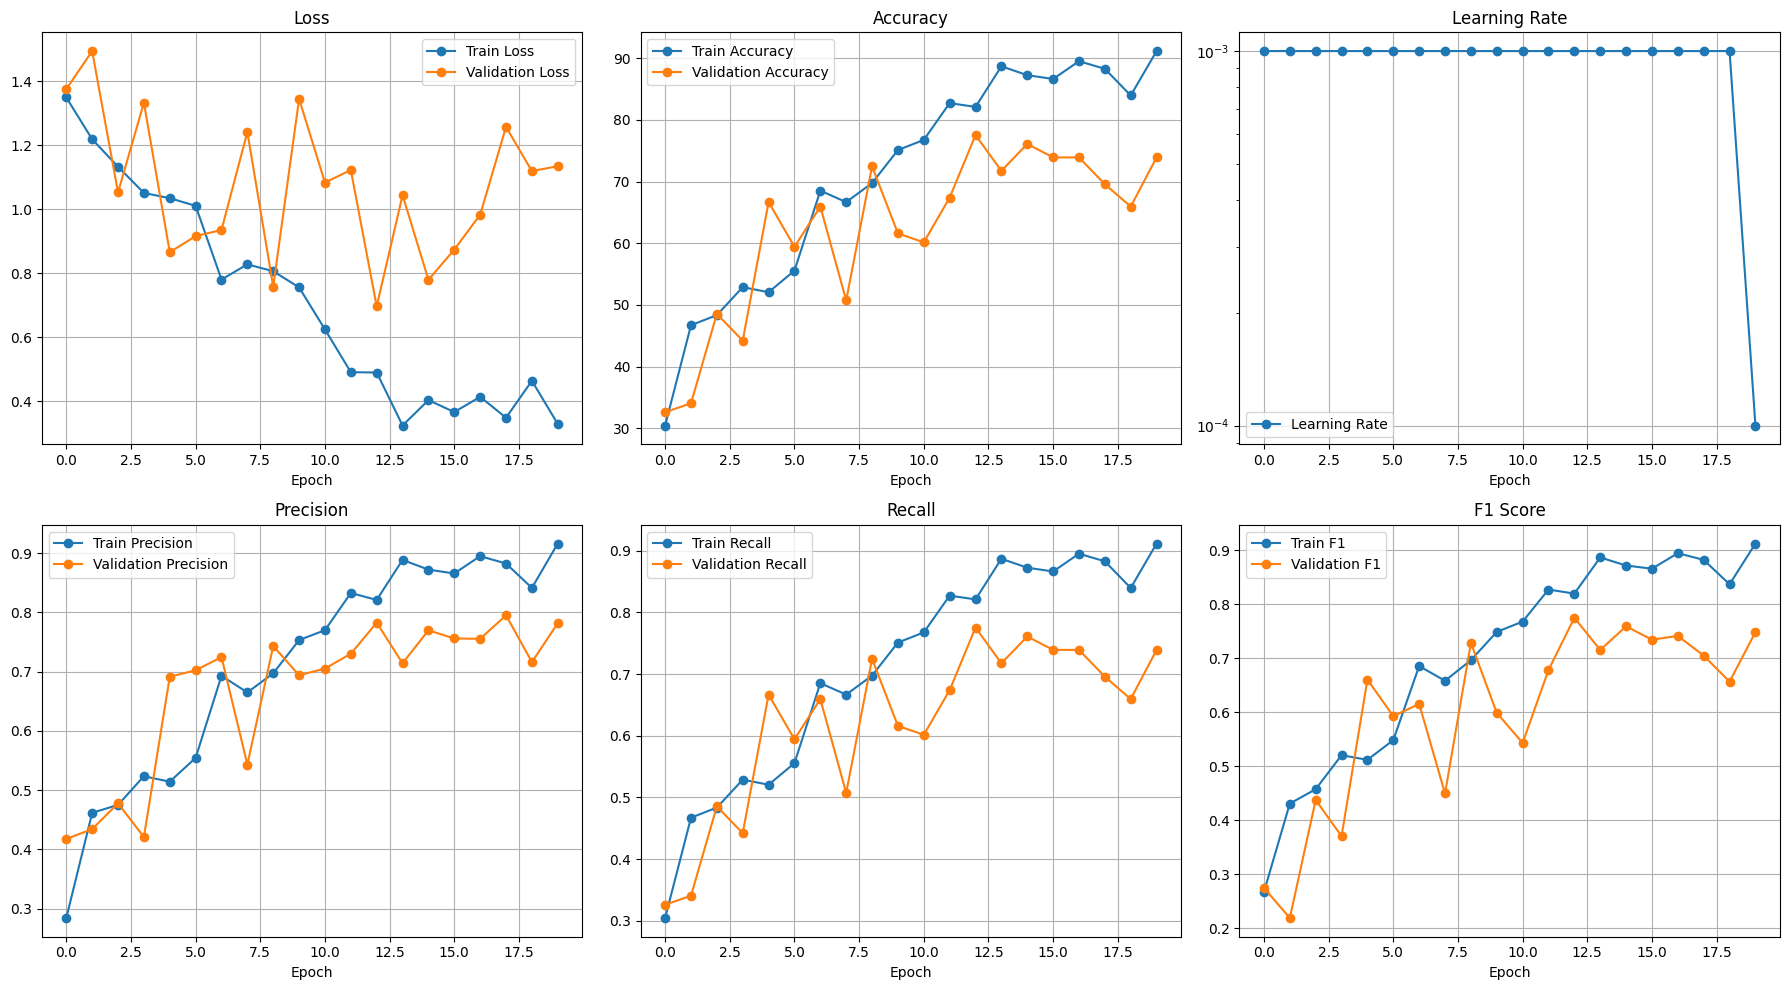

Testing:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipytho

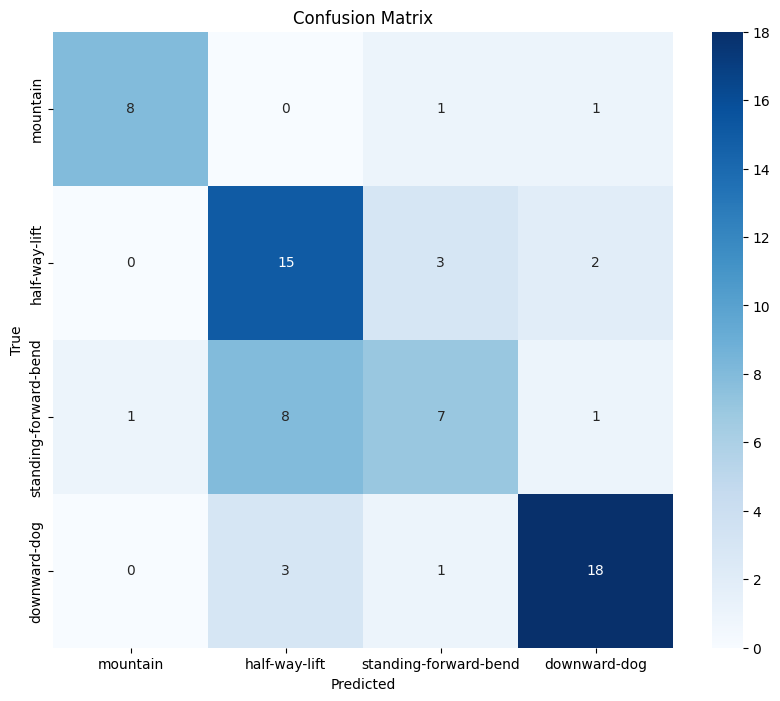

Test Loss: 0.8491
Test Accuracy: 69.57%


In [16]:
plot_training_curves(history)
if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(
            model, optimizer, checkpoint_path
        )
        print(f"Resuming training from epoch {start_epoch}")
evaluate_model(model, test_loader, criterion, pose_list)

model_save_path = os.path.join(save_path, 'my_model.pth')
torch.save(model.state_dict(), model_save_path)

Loading checkpoint from /content/gdrive/MyDrive/RGB_data_stream/SECOND_mobile_net_nov2/best_model.pth


<ipython-input-17-04d0bcd412bb>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 13


Testing:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-5-059fa69835f7>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(preprocessed_path)
<ipytho

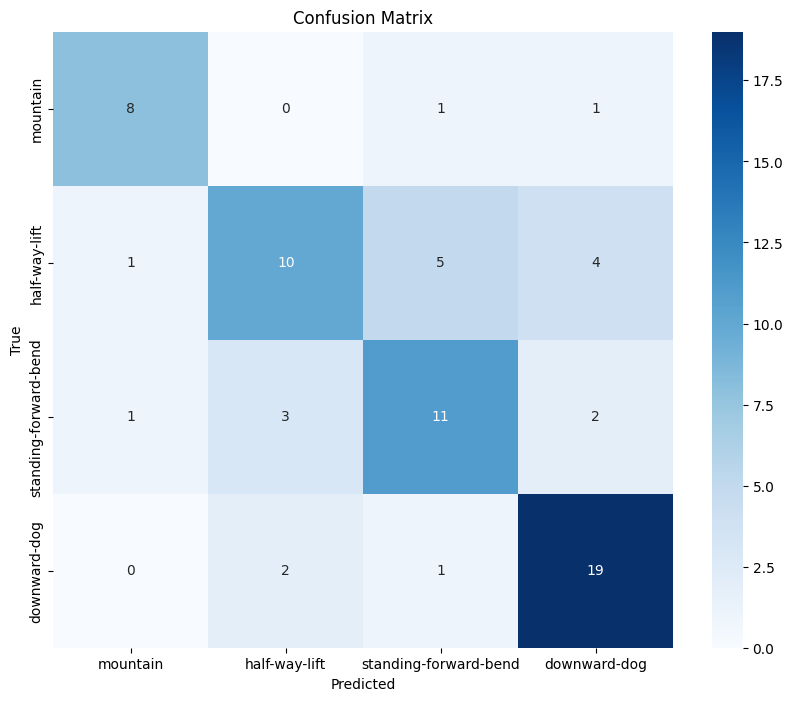

Test Loss: 0.9201
Test Accuracy: 69.57%


(0.9200764894485474, 69.56521739130434)

In [20]:
checkpoint_path = os.path.join(save_path, 'best_model.pth')
if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(
            model, optimizer, checkpoint_path
        )
        print(f"Resuming training from epoch {start_epoch}")
evaluate_model(model, test_loader, criterion, pose_list)